In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F
import torchvision

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from medsegbench import UltrasoundNerveMSBench
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

from torch.utils.data import Dataset
import torchvision.transforms as transforms


In [4]:
# For reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Name of device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Using device: cuda
Name of device: NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
# Transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset loading (256x256 as required)
train_dataset = UltrasoundNerveMSBench(split='train', size=256, transform=transform, target_transform=transform, download=True)
val_dataset = UltrasoundNerveMSBench(split='val', size=256, transform=transform, target_transform=transform, download=True)
test_dataset = UltrasoundNerveMSBench(split='test', size=256, transform=transform, target_transform=transform, download=True)

batchsize = 8

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Print dataset details for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

print(f"Image size: {train_dataset[0][0].shape}")
print(f"Label size: {train_dataset[0][1].shape}")

Train samples: 1651
Validation samples: 223
Test samples: 449
Image size: torch.Size([1, 256, 256])
Label size: torch.Size([1, 256, 256])


In [7]:
class UNetResNet18(nn.Module):
    def __init__(self, out_channels=1, pretrained=True):
        super().__init__()
        resnet = models.resnet18(pretrained=pretrained)
        # Encoder
        self.input_layer = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.maxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder layers (upsampling + conv)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)
        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.input_layer(x)    # 64, 128x128
        x2 = self.maxpool(x1)       # 64, 64x64
        x3 = self.encoder1(x2)      # 64, 64x64
        x4 = self.encoder2(x3)      # 128, 32x32
        x5 = self.encoder3(x4)      # 256, 16x16
        x6 = self.encoder4(x5)      # 512, 8x8

        # Decoder with skip connections
        d1 = self.up1(x6)           # 256, 16x16
        d1 = self._cat_and_pad(d1, x5)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)           # 128, 32x32
        d2 = self._cat_and_pad(d2, x4)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)           # 64, 64x64
        d3 = self._cat_and_pad(d3, x3)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)           # 64, 128x128
        d4 = self._cat_and_pad(d4, x1)
        d4 = self.dec4(d4)

        out = nn.functional.interpolate(d4, scale_factor=2, mode="bilinear", align_corners=False)  # 64, 256x256
        out = self.final_conv(out)  # out_channels, 256x256

        return out

    def _cat_and_pad(self, upsampled, bypass):
        # Pads upsampled to match bypass, then concatenates along channel dimension
        if upsampled.shape[-2:] != bypass.shape[-2:]:
            upsampled = nn.functional.interpolate(upsampled, size=bypass.shape[-2:], mode="bilinear", align_corners=False)
        return torch.cat([upsampled, bypass], dim=1)

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # If logits are not probabilities, apply sigmoid
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(1,2))
        union = probs.sum(dim=(1,2)) + targets.sum(dim=(1,2))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [80]:
""" class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss(smooth=smooth)
    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets) """

' class BCEDiceLoss(nn.Module):\n    def __init__(self, smooth=1e-5):\n        super().__init__()\n        self.bce = nn.BCEWithLogitsLoss()\n        self.dice = DiceLoss(smooth=smooth)\n    def forward(self, logits, targets):\n        return self.bce(logits, targets) + self.dice(logits, targets) '

In [9]:
# --- Hyperparameters ---
num_epochs = 150
batch_size = 8    # should match your loader
learning_rate = 1e-4
log_dir = "runs/150epochDicelossexperiment9"
model_save_path = "best_model.pth"

# --- Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18(out_channels=1, pretrained=True).to(device)
criterion = DiceLoss()  # for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\acur1\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\acur1\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# --- TensorBoard Writer ---
writer = SummaryWriter(log_dir=log_dir)

def to_3channel(img_tensor):
    """Repeat single channel to 3 channels for ResNet18 input."""
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

def sigmoid_output(outputs):
    return torch.sigmoid(outputs)

def calc_accuracy(outputs, labels, threshold=0.5):
    preds = sigmoid_output(outputs) > threshold
    correct = (preds == labels).float()
    return correct.sum() / torch.numel(correct)


In [83]:
# --- Training and Validation Loop ---
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = to_3channel(images).to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)  # [B, H, W]
        masks = masks.squeeze(1)      # [B, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_acc += calc_accuracy(outputs, masks) * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images = to_3channel(images).to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = outputs.squeeze(1)
            masks = masks.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_acc += calc_accuracy(outputs, masks) * images.size(0)
            # Log images to TensorBoard (only for first batch of each epoch)
            if i == 0:
                grid_input = torchvision.utils.make_grid(images[:, 0:1], normalize=True)
                grid_pred = torchvision.utils.make_grid((sigmoid_output(outputs) > 0.5).float().unsqueeze(1), normalize=True)
                grid_target = torchvision.utils.make_grid(masks.unsqueeze(1), normalize=True)
                writer.add_image('val/input_image', grid_input, epoch)
                writer.add_image('val/predicted_segmented_image', grid_pred, epoch)
                writer.add_image('val/target_image', grid_target, epoch)
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # --- TensorBoard Logging ---
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # --- Save Best Model ---
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), model_save_path)
        best_val_loss = val_loss
        print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")

writer.close()
print("Training complete. Best model saved to:", model_save_path)

Epoch 1/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 1/150 | Train Loss: 0.8195 | Val Loss: 0.7636 | Train Acc: 0.9119 | Val Acc: 0.9682
Best model saved at epoch 1 with validation loss: 0.7636


Epoch 2/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.77it/s]


Epoch 2/150 | Train Loss: 0.7141 | Val Loss: 0.6672 | Train Acc: 0.9744 | Val Acc: 0.9826
Best model saved at epoch 2 with validation loss: 0.6672


Epoch 3/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.87it/s]


Epoch 3/150 | Train Loss: 0.5928 | Val Loss: 0.5531 | Train Acc: 0.9835 | Val Acc: 0.9846
Best model saved at epoch 3 with validation loss: 0.5531


Epoch 4/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 17.05it/s]


Epoch 4/150 | Train Loss: 0.4589 | Val Loss: 0.4324 | Train Acc: 0.9877 | Val Acc: 0.9867
Best model saved at epoch 4 with validation loss: 0.4324


Epoch 5/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 17.01it/s]


Epoch 5/150 | Train Loss: 0.3456 | Val Loss: 0.3446 | Train Acc: 0.9901 | Val Acc: 0.9886
Best model saved at epoch 5 with validation loss: 0.3446


Epoch 6/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.81it/s]


Epoch 6/150 | Train Loss: 0.2679 | Val Loss: 0.2932 | Train Acc: 0.9914 | Val Acc: 0.9879
Best model saved at epoch 6 with validation loss: 0.2932


Epoch 7/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.55it/s]


Epoch 7/150 | Train Loss: 0.2184 | Val Loss: 0.2685 | Train Acc: 0.9921 | Val Acc: 0.9887
Best model saved at epoch 7 with validation loss: 0.2685


Epoch 8/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.49it/s]


Epoch 8/150 | Train Loss: 0.1825 | Val Loss: 0.2473 | Train Acc: 0.9929 | Val Acc: 0.9887
Best model saved at epoch 8 with validation loss: 0.2473


Epoch 9/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.48it/s]


Epoch 9/150 | Train Loss: 0.1587 | Val Loss: 0.2272 | Train Acc: 0.9934 | Val Acc: 0.9887
Best model saved at epoch 9 with validation loss: 0.2272


Epoch 10/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 10/150 | Train Loss: 0.1394 | Val Loss: 0.2299 | Train Acc: 0.9939 | Val Acc: 0.9887


Epoch 11/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.41it/s]


Epoch 11/150 | Train Loss: 0.1251 | Val Loss: 0.2221 | Train Acc: 0.9943 | Val Acc: 0.9890
Best model saved at epoch 11 with validation loss: 0.2221


Epoch 12/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 12/150 | Train Loss: 0.1143 | Val Loss: 0.2187 | Train Acc: 0.9946 | Val Acc: 0.9885
Best model saved at epoch 12 with validation loss: 0.2187


Epoch 13/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.35it/s]


Epoch 13/150 | Train Loss: 0.1061 | Val Loss: 0.2212 | Train Acc: 0.9948 | Val Acc: 0.9887


Epoch 14/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.38it/s]


Epoch 14/150 | Train Loss: 0.0998 | Val Loss: 0.2205 | Train Acc: 0.9950 | Val Acc: 0.9885


Epoch 15/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.32it/s]


Epoch 15/150 | Train Loss: 0.0921 | Val Loss: 0.2168 | Train Acc: 0.9953 | Val Acc: 0.9881
Best model saved at epoch 15 with validation loss: 0.2168


Epoch 16/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 16/150 | Train Loss: 0.0864 | Val Loss: 0.2124 | Train Acc: 0.9956 | Val Acc: 0.9886
Best model saved at epoch 16 with validation loss: 0.2124


Epoch 17/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 17/150 | Train Loss: 0.0814 | Val Loss: 0.2148 | Train Acc: 0.9957 | Val Acc: 0.9887


Epoch 18/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.18it/s]


Epoch 18/150 | Train Loss: 0.0781 | Val Loss: 0.2185 | Train Acc: 0.9959 | Val Acc: 0.9884


Epoch 19/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.23it/s]


Epoch 19/150 | Train Loss: 0.0749 | Val Loss: 0.2117 | Train Acc: 0.9960 | Val Acc: 0.9886
Best model saved at epoch 19 with validation loss: 0.2117


Epoch 20/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.23it/s]


Epoch 20/150 | Train Loss: 0.0720 | Val Loss: 0.2183 | Train Acc: 0.9961 | Val Acc: 0.9885


Epoch 21/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.19it/s]


Epoch 21/150 | Train Loss: 0.0692 | Val Loss: 0.2073 | Train Acc: 0.9962 | Val Acc: 0.9884
Best model saved at epoch 21 with validation loss: 0.2073


Epoch 22/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.24it/s]


Epoch 22/150 | Train Loss: 0.0680 | Val Loss: 0.2126 | Train Acc: 0.9963 | Val Acc: 0.9887


Epoch 23/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.18it/s]


Epoch 23/150 | Train Loss: 0.0658 | Val Loss: 0.2119 | Train Acc: 0.9964 | Val Acc: 0.9883


Epoch 24/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.23it/s]


Epoch 24/150 | Train Loss: 0.0634 | Val Loss: 0.2071 | Train Acc: 0.9965 | Val Acc: 0.9886
Best model saved at epoch 24 with validation loss: 0.2071


Epoch 25/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.25it/s]


Epoch 25/150 | Train Loss: 0.0612 | Val Loss: 0.2089 | Train Acc: 0.9966 | Val Acc: 0.9884


Epoch 26/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.25it/s]


Epoch 26/150 | Train Loss: 0.0605 | Val Loss: 0.2109 | Train Acc: 0.9966 | Val Acc: 0.9884


Epoch 27/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.25it/s]


Epoch 27/150 | Train Loss: 0.0589 | Val Loss: 0.2126 | Train Acc: 0.9967 | Val Acc: 0.9885


Epoch 28/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.18it/s]


Epoch 28/150 | Train Loss: 0.0583 | Val Loss: 0.2105 | Train Acc: 0.9967 | Val Acc: 0.9884


Epoch 29/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 29/150 | Train Loss: 0.0565 | Val Loss: 0.2062 | Train Acc: 0.9968 | Val Acc: 0.9886
Best model saved at epoch 29 with validation loss: 0.2062


Epoch 30/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 30/150 | Train Loss: 0.0556 | Val Loss: 0.2079 | Train Acc: 0.9968 | Val Acc: 0.9884


Epoch 31/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.10it/s]


Epoch 31/150 | Train Loss: 0.0534 | Val Loss: 0.2086 | Train Acc: 0.9970 | Val Acc: 0.9883


Epoch 32/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.24it/s]


Epoch 32/150 | Train Loss: 0.0525 | Val Loss: 0.2080 | Train Acc: 0.9970 | Val Acc: 0.9887


Epoch 33/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.21it/s]


Epoch 33/150 | Train Loss: 0.0513 | Val Loss: 0.2089 | Train Acc: 0.9971 | Val Acc: 0.9884


Epoch 34/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 34/150 | Train Loss: 0.0509 | Val Loss: 0.2121 | Train Acc: 0.9971 | Val Acc: 0.9884


Epoch 35/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 35/150 | Train Loss: 0.0493 | Val Loss: 0.2085 | Train Acc: 0.9972 | Val Acc: 0.9886


Epoch 36/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.10it/s]


Epoch 36/150 | Train Loss: 0.0491 | Val Loss: 0.2081 | Train Acc: 0.9972 | Val Acc: 0.9886


Epoch 37/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.15it/s]


Epoch 37/150 | Train Loss: 0.0486 | Val Loss: 0.2084 | Train Acc: 0.9972 | Val Acc: 0.9884


Epoch 38/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.08it/s]


Epoch 38/150 | Train Loss: 0.0480 | Val Loss: 0.2078 | Train Acc: 0.9972 | Val Acc: 0.9886


Epoch 39/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.21it/s]


Epoch 39/150 | Train Loss: 0.0473 | Val Loss: 0.2096 | Train Acc: 0.9972 | Val Acc: 0.9886


Epoch 40/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.20it/s]


Epoch 40/150 | Train Loss: 0.0464 | Val Loss: 0.2075 | Train Acc: 0.9973 | Val Acc: 0.9884


Epoch 41/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.09it/s]


Epoch 41/150 | Train Loss: 0.0456 | Val Loss: 0.2105 | Train Acc: 0.9974 | Val Acc: 0.9885


Epoch 42/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 42/150 | Train Loss: 0.0450 | Val Loss: 0.2097 | Train Acc: 0.9974 | Val Acc: 0.9881


Epoch 43/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.15it/s]


Epoch 43/150 | Train Loss: 0.0446 | Val Loss: 0.2116 | Train Acc: 0.9974 | Val Acc: 0.9886


Epoch 44/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.15it/s]


Epoch 44/150 | Train Loss: 0.0442 | Val Loss: 0.2120 | Train Acc: 0.9974 | Val Acc: 0.9885


Epoch 45/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.19it/s]


Epoch 45/150 | Train Loss: 0.0433 | Val Loss: 0.2107 | Train Acc: 0.9975 | Val Acc: 0.9886


Epoch 46/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 46/150 | Train Loss: 0.0439 | Val Loss: 0.2104 | Train Acc: 0.9974 | Val Acc: 0.9887


Epoch 47/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 47/150 | Train Loss: 0.0433 | Val Loss: 0.2111 | Train Acc: 0.9975 | Val Acc: 0.9885


Epoch 48/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.09it/s]


Epoch 48/150 | Train Loss: 0.0423 | Val Loss: 0.2117 | Train Acc: 0.9975 | Val Acc: 0.9886


Epoch 49/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.17it/s]


Epoch 49/150 | Train Loss: 0.0417 | Val Loss: 0.2084 | Train Acc: 0.9976 | Val Acc: 0.9887


Epoch 50/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 50/150 | Train Loss: 0.0408 | Val Loss: 0.2079 | Train Acc: 0.9976 | Val Acc: 0.9885


Epoch 51/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 51/150 | Train Loss: 0.0404 | Val Loss: 0.2114 | Train Acc: 0.9976 | Val Acc: 0.9886


Epoch 52/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.07it/s]


Epoch 52/150 | Train Loss: 0.0400 | Val Loss: 0.2106 | Train Acc: 0.9976 | Val Acc: 0.9885


Epoch 53/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.10it/s]


Epoch 53/150 | Train Loss: 0.0402 | Val Loss: 0.2134 | Train Acc: 0.9976 | Val Acc: 0.9885


Epoch 54/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.18it/s]


Epoch 54/150 | Train Loss: 0.0390 | Val Loss: 0.2150 | Train Acc: 0.9977 | Val Acc: 0.9886


Epoch 55/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.13it/s]


Epoch 55/150 | Train Loss: 0.0391 | Val Loss: 0.2258 | Train Acc: 0.9977 | Val Acc: 0.9882


Epoch 56/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.10it/s]


Epoch 56/150 | Train Loss: 0.0396 | Val Loss: 0.2156 | Train Acc: 0.9977 | Val Acc: 0.9886


Epoch 57/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 57/150 | Train Loss: 0.0392 | Val Loss: 0.2148 | Train Acc: 0.9977 | Val Acc: 0.9884


Epoch 58/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 58/150 | Train Loss: 0.0388 | Val Loss: 0.2122 | Train Acc: 0.9977 | Val Acc: 0.9885


Epoch 59/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.17it/s]


Epoch 59/150 | Train Loss: 0.0384 | Val Loss: 0.2121 | Train Acc: 0.9977 | Val Acc: 0.9885


Epoch 60/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.17it/s]


Epoch 60/150 | Train Loss: 0.0373 | Val Loss: 0.2147 | Train Acc: 0.9978 | Val Acc: 0.9885


Epoch 61/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.17it/s]


Epoch 61/150 | Train Loss: 0.0369 | Val Loss: 0.2136 | Train Acc: 0.9978 | Val Acc: 0.9885


Epoch 62/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.11it/s]


Epoch 62/150 | Train Loss: 0.0367 | Val Loss: 0.2104 | Train Acc: 0.9978 | Val Acc: 0.9886


Epoch 63/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.18it/s]


Epoch 63/150 | Train Loss: 0.0366 | Val Loss: 0.2170 | Train Acc: 0.9978 | Val Acc: 0.9885


Epoch 64/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.10it/s]


Epoch 64/150 | Train Loss: 0.0364 | Val Loss: 0.2135 | Train Acc: 0.9979 | Val Acc: 0.9885


Epoch 65/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 65/150 | Train Loss: 0.0363 | Val Loss: 0.2135 | Train Acc: 0.9979 | Val Acc: 0.9886


Epoch 66/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.01it/s]


Epoch 66/150 | Train Loss: 0.0358 | Val Loss: 0.2118 | Train Acc: 0.9979 | Val Acc: 0.9885


Epoch 67/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.04it/s]


Epoch 67/150 | Train Loss: 0.0349 | Val Loss: 0.2135 | Train Acc: 0.9979 | Val Acc: 0.9885


Epoch 68/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.08it/s]


Epoch 68/150 | Train Loss: 0.0346 | Val Loss: 0.2140 | Train Acc: 0.9980 | Val Acc: 0.9886


Epoch 69/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.75it/s]


Epoch 69/150 | Train Loss: 0.0346 | Val Loss: 0.2201 | Train Acc: 0.9980 | Val Acc: 0.9884


Epoch 70/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 70/150 | Train Loss: 0.0347 | Val Loss: 0.2164 | Train Acc: 0.9980 | Val Acc: 0.9885


Epoch 71/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.16it/s]


Epoch 71/150 | Train Loss: 0.0343 | Val Loss: 0.2160 | Train Acc: 0.9980 | Val Acc: 0.9886


Epoch 72/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.14it/s]


Epoch 72/150 | Train Loss: 0.0342 | Val Loss: 0.2113 | Train Acc: 0.9980 | Val Acc: 0.9886


Epoch 73/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.30it/s]


Epoch 73/150 | Train Loss: 0.0336 | Val Loss: 0.2252 | Train Acc: 0.9980 | Val Acc: 0.9884


Epoch 74/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.32it/s]


Epoch 74/150 | Train Loss: 0.0329 | Val Loss: 0.2162 | Train Acc: 0.9981 | Val Acc: 0.9886


Epoch 75/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 75/150 | Train Loss: 0.0329 | Val Loss: 0.2137 | Train Acc: 0.9981 | Val Acc: 0.9885


Epoch 76/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.27it/s]


Epoch 76/150 | Train Loss: 0.0329 | Val Loss: 0.2108 | Train Acc: 0.9981 | Val Acc: 0.9886


Epoch 77/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.38it/s]


Epoch 77/150 | Train Loss: 0.0324 | Val Loss: 0.2126 | Train Acc: 0.9981 | Val Acc: 0.9886


Epoch 78/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.36it/s]


Epoch 78/150 | Train Loss: 0.0321 | Val Loss: 0.2138 | Train Acc: 0.9981 | Val Acc: 0.9885


Epoch 79/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.32it/s]


Epoch 79/150 | Train Loss: 0.0319 | Val Loss: 0.2125 | Train Acc: 0.9981 | Val Acc: 0.9886


Epoch 80/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 80/150 | Train Loss: 0.0321 | Val Loss: 0.2097 | Train Acc: 0.9981 | Val Acc: 0.9887


Epoch 81/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.45it/s]


Epoch 81/150 | Train Loss: 0.0316 | Val Loss: 0.2211 | Train Acc: 0.9981 | Val Acc: 0.9884


Epoch 82/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.35it/s]


Epoch 82/150 | Train Loss: 0.0321 | Val Loss: 0.2178 | Train Acc: 0.9981 | Val Acc: 0.9885


Epoch 83/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.47it/s]


Epoch 83/150 | Train Loss: 0.0315 | Val Loss: 0.2137 | Train Acc: 0.9981 | Val Acc: 0.9886


Epoch 84/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 84/150 | Train Loss: 0.0312 | Val Loss: 0.2100 | Train Acc: 0.9982 | Val Acc: 0.9885


Epoch 85/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.33it/s]


Epoch 85/150 | Train Loss: 0.0308 | Val Loss: 0.2118 | Train Acc: 0.9982 | Val Acc: 0.9885


Epoch 86/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.47it/s]


Epoch 86/150 | Train Loss: 0.0304 | Val Loss: 0.2142 | Train Acc: 0.9982 | Val Acc: 0.9885


Epoch 87/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.47it/s]


Epoch 87/150 | Train Loss: 0.0305 | Val Loss: 0.2201 | Train Acc: 0.9982 | Val Acc: 0.9885


Epoch 88/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.46it/s]


Epoch 88/150 | Train Loss: 0.0304 | Val Loss: 0.2229 | Train Acc: 0.9982 | Val Acc: 0.9884


Epoch 89/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 89/150 | Train Loss: 0.0303 | Val Loss: 0.2197 | Train Acc: 0.9982 | Val Acc: 0.9885


Epoch 90/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 90/150 | Train Loss: 0.0302 | Val Loss: 0.2202 | Train Acc: 0.9982 | Val Acc: 0.9884


Epoch 91/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 91/150 | Train Loss: 0.0295 | Val Loss: 0.2234 | Train Acc: 0.9983 | Val Acc: 0.9884


Epoch 92/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 92/150 | Train Loss: 0.0295 | Val Loss: 0.2277 | Train Acc: 0.9983 | Val Acc: 0.9883


Epoch 93/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 93/150 | Train Loss: 0.0290 | Val Loss: 0.2186 | Train Acc: 0.9983 | Val Acc: 0.9886


Epoch 94/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 94/150 | Train Loss: 0.0295 | Val Loss: 0.2202 | Train Acc: 0.9983 | Val Acc: 0.9884


Epoch 95/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.33it/s]


Epoch 95/150 | Train Loss: 0.0294 | Val Loss: 0.2164 | Train Acc: 0.9983 | Val Acc: 0.9885


Epoch 96/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.45it/s]


Epoch 96/150 | Train Loss: 0.0288 | Val Loss: 0.2176 | Train Acc: 0.9983 | Val Acc: 0.9884


Epoch 97/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 97/150 | Train Loss: 0.0298 | Val Loss: 0.2235 | Train Acc: 0.9982 | Val Acc: 0.9883


Epoch 98/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.32it/s]


Epoch 98/150 | Train Loss: 0.0291 | Val Loss: 0.2256 | Train Acc: 0.9983 | Val Acc: 0.9883


Epoch 99/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.49it/s]


Epoch 99/150 | Train Loss: 0.0281 | Val Loss: 0.2218 | Train Acc: 0.9983 | Val Acc: 0.9883


Epoch 100/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 100/150 | Train Loss: 0.0272 | Val Loss: 0.2183 | Train Acc: 0.9984 | Val Acc: 0.9885


Epoch 101/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.41it/s]


Epoch 101/150 | Train Loss: 0.0276 | Val Loss: 0.2215 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 102/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 102/150 | Train Loss: 0.0277 | Val Loss: 0.2231 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 103/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 103/150 | Train Loss: 0.0277 | Val Loss: 0.2221 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 104/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.46it/s]


Epoch 104/150 | Train Loss: 0.0275 | Val Loss: 0.2206 | Train Acc: 0.9984 | Val Acc: 0.9883


Epoch 105/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 105/150 | Train Loss: 0.0276 | Val Loss: 0.2246 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 106/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 106/150 | Train Loss: 0.0271 | Val Loss: 0.2212 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 107/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 107/150 | Train Loss: 0.0273 | Val Loss: 0.2179 | Train Acc: 0.9984 | Val Acc: 0.9883


Epoch 108/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.31it/s]


Epoch 108/150 | Train Loss: 0.0269 | Val Loss: 0.2168 | Train Acc: 0.9984 | Val Acc: 0.9885


Epoch 109/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 109/150 | Train Loss: 0.0274 | Val Loss: 0.2224 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 110/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 110/150 | Train Loss: 0.0268 | Val Loss: 0.2266 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 111/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 111/150 | Train Loss: 0.0268 | Val Loss: 0.2225 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 112/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.38it/s]


Epoch 112/150 | Train Loss: 0.0263 | Val Loss: 0.2217 | Train Acc: 0.9984 | Val Acc: 0.9884


Epoch 113/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 113/150 | Train Loss: 0.0265 | Val Loss: 0.2147 | Train Acc: 0.9984 | Val Acc: 0.9885


Epoch 114/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 114/150 | Train Loss: 0.0262 | Val Loss: 0.2192 | Train Acc: 0.9985 | Val Acc: 0.9884


Epoch 115/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.31it/s]


Epoch 115/150 | Train Loss: 0.0257 | Val Loss: 0.2272 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 116/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.47it/s]


Epoch 116/150 | Train Loss: 0.0256 | Val Loss: 0.2232 | Train Acc: 0.9985 | Val Acc: 0.9884


Epoch 117/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 117/150 | Train Loss: 0.0263 | Val Loss: 0.2353 | Train Acc: 0.9984 | Val Acc: 0.9883


Epoch 118/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 118/150 | Train Loss: 0.0258 | Val Loss: 0.2286 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 119/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.41it/s]


Epoch 119/150 | Train Loss: 0.0249 | Val Loss: 0.2260 | Train Acc: 0.9985 | Val Acc: 0.9884


Epoch 120/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.36it/s]


Epoch 120/150 | Train Loss: 0.0248 | Val Loss: 0.2338 | Train Acc: 0.9985 | Val Acc: 0.9882


Epoch 121/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.41it/s]


Epoch 121/150 | Train Loss: 0.0250 | Val Loss: 0.2275 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 122/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 122/150 | Train Loss: 0.0252 | Val Loss: 0.2275 | Train Acc: 0.9985 | Val Acc: 0.9884


Epoch 123/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.44it/s]


Epoch 123/150 | Train Loss: 0.0250 | Val Loss: 0.2260 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 124/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.34it/s]


Epoch 124/150 | Train Loss: 0.0245 | Val Loss: 0.2277 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 125/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 125/150 | Train Loss: 0.0247 | Val Loss: 0.2331 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 126/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 126/150 | Train Loss: 0.0254 | Val Loss: 0.2219 | Train Acc: 0.9985 | Val Acc: 0.9885


Epoch 127/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.44it/s]


Epoch 127/150 | Train Loss: 0.0249 | Val Loss: 0.2265 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 128/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 128/150 | Train Loss: 0.0242 | Val Loss: 0.2256 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 129/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 129/150 | Train Loss: 0.0246 | Val Loss: 0.2219 | Train Acc: 0.9985 | Val Acc: 0.9885


Epoch 130/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.43it/s]


Epoch 130/150 | Train Loss: 0.0246 | Val Loss: 0.2180 | Train Acc: 0.9985 | Val Acc: 0.9886


Epoch 131/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 131/150 | Train Loss: 0.0240 | Val Loss: 0.2194 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 132/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.40it/s]


Epoch 132/150 | Train Loss: 0.0240 | Val Loss: 0.2239 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 133/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 133/150 | Train Loss: 0.0244 | Val Loss: 0.2183 | Train Acc: 0.9986 | Val Acc: 0.9885


Epoch 134/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.37it/s]


Epoch 134/150 | Train Loss: 0.0241 | Val Loss: 0.2202 | Train Acc: 0.9986 | Val Acc: 0.9885


Epoch 135/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 135/150 | Train Loss: 0.0234 | Val Loss: 0.2251 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 136/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 136/150 | Train Loss: 0.0236 | Val Loss: 0.2250 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 137/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.34it/s]


Epoch 137/150 | Train Loss: 0.0236 | Val Loss: 0.2238 | Train Acc: 0.9986 | Val Acc: 0.9885


Epoch 138/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.46it/s]


Epoch 138/150 | Train Loss: 0.0232 | Val Loss: 0.2226 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 139/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 139/150 | Train Loss: 0.0234 | Val Loss: 0.2314 | Train Acc: 0.9986 | Val Acc: 0.9883


Epoch 140/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 140/150 | Train Loss: 0.0235 | Val Loss: 0.2322 | Train Acc: 0.9986 | Val Acc: 0.9883


Epoch 141/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.34it/s]


Epoch 141/150 | Train Loss: 0.0232 | Val Loss: 0.2302 | Train Acc: 0.9986 | Val Acc: 0.9883


Epoch 142/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.33it/s]


Epoch 142/150 | Train Loss: 0.0232 | Val Loss: 0.2277 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 143/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.51it/s]


Epoch 143/150 | Train Loss: 0.0236 | Val Loss: 0.2262 | Train Acc: 0.9986 | Val Acc: 0.9883


Epoch 144/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 144/150 | Train Loss: 0.0243 | Val Loss: 0.2108 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 145/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.29it/s]


Epoch 145/150 | Train Loss: 0.0253 | Val Loss: 0.2354 | Train Acc: 0.9985 | Val Acc: 0.9883


Epoch 146/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 146/150 | Train Loss: 0.0238 | Val Loss: 0.2286 | Train Acc: 0.9986 | Val Acc: 0.9884


Epoch 147/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.39it/s]


Epoch 147/150 | Train Loss: 0.0230 | Val Loss: 0.2257 | Train Acc: 0.9986 | Val Acc: 0.9883


Epoch 148/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.48it/s]


Epoch 148/150 | Train Loss: 0.0225 | Val Loss: 0.2291 | Train Acc: 0.9987 | Val Acc: 0.9883


Epoch 149/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.42it/s]


Epoch 149/150 | Train Loss: 0.0222 | Val Loss: 0.2198 | Train Acc: 0.9987 | Val Acc: 0.9885


Epoch 150/150 [Train]: 100%|██████████| 207/207 [00:12<00:00, 16.34it/s]


Epoch 150/150 | Train Loss: 0.0220 | Val Loss: 0.2283 | Train Acc: 0.9987 | Val Acc: 0.9884
Training complete. Best model saved to: best_model.pth


In [84]:
# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18(out_channels=1, pretrained=True).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def to_3channel(img_tensor):
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in test_loader:
        images = to_3channel(images).to(device)
        masks = masks.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).cpu().numpy().astype("uint8")
        targets = masks.cpu().numpy().astype("uint8")
        # Flatten for metric computation
        all_preds.append(preds.reshape(-1))
        all_targets.append(targets.reshape(-1))

# Concatenate all results
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
f1 = f1_score(all_targets, all_preds, zero_division=0)
iou = jaccard_score(all_targets, all_preds, zero_division=0)

print(f"Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

Test Metrics:
Accuracy:  0.9883
Precision: 0.8115
Recall:    0.7877
F1-Score:  0.7994
IoU:       0.6659


c:\Users\acur1\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\acur1\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


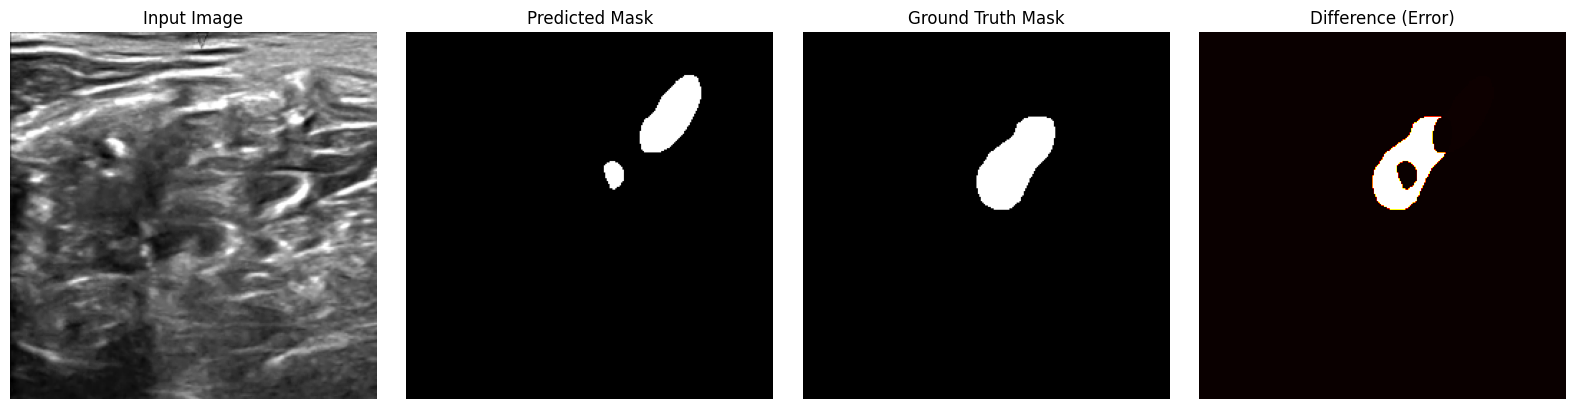

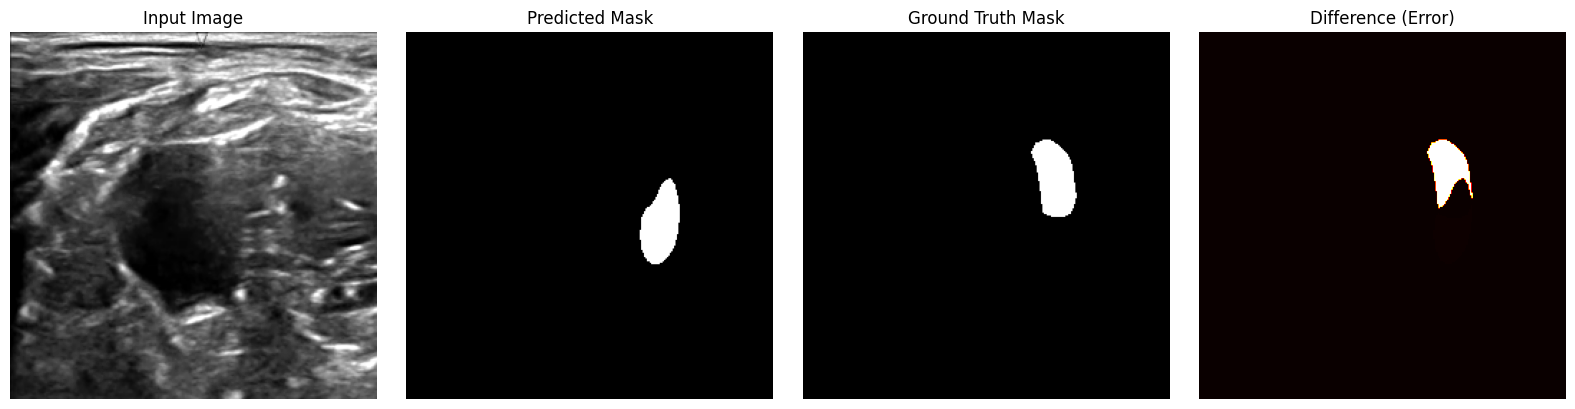

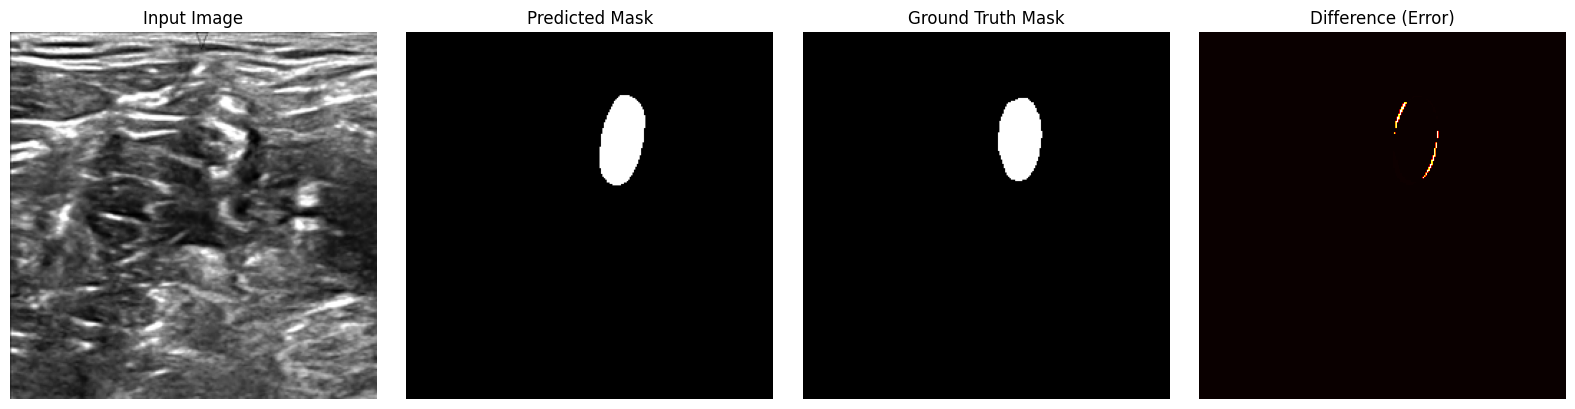

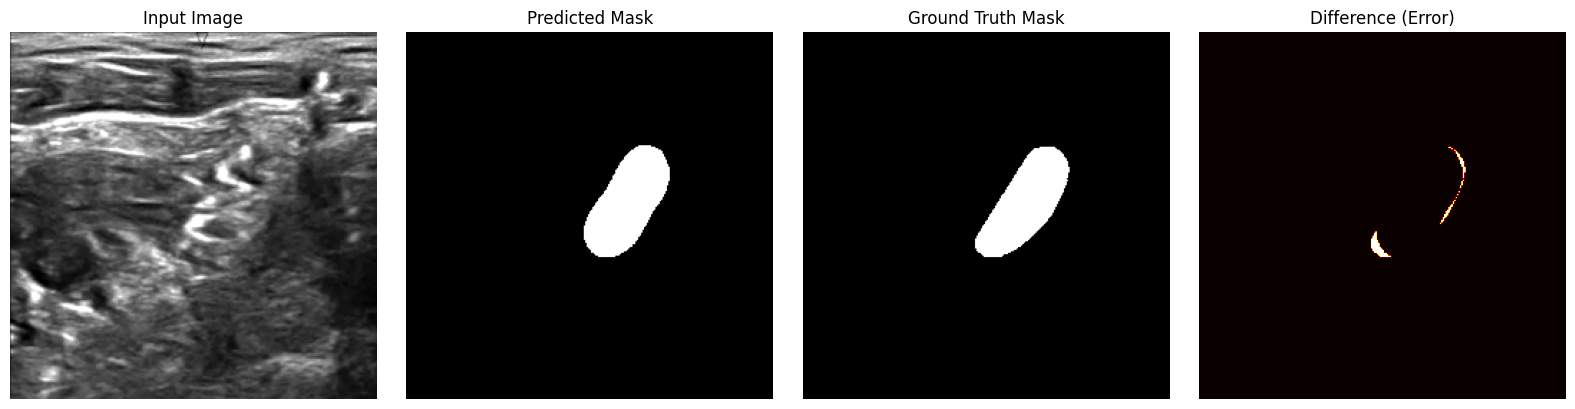

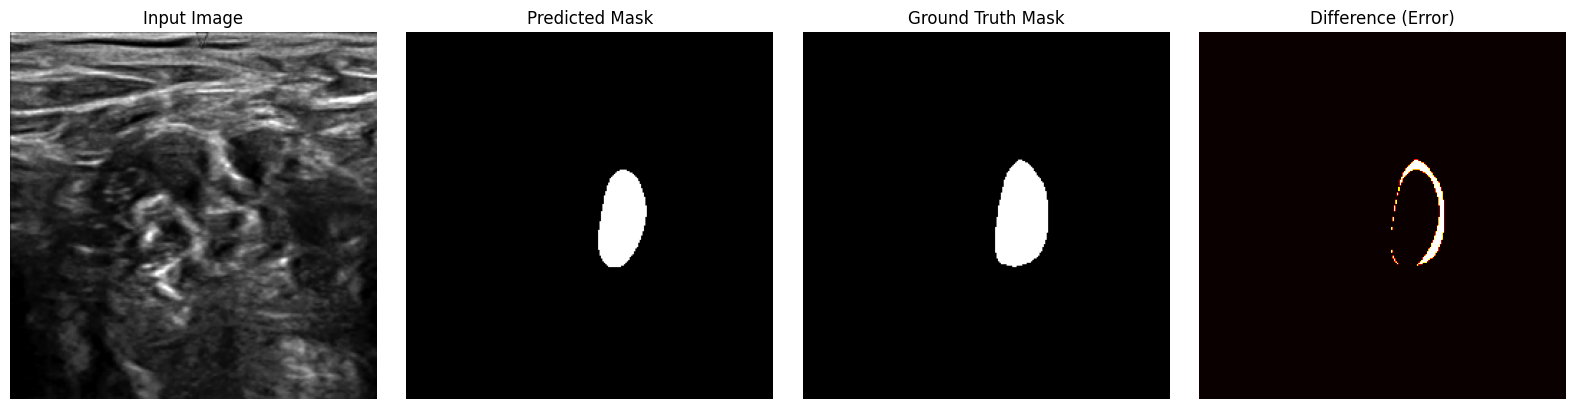

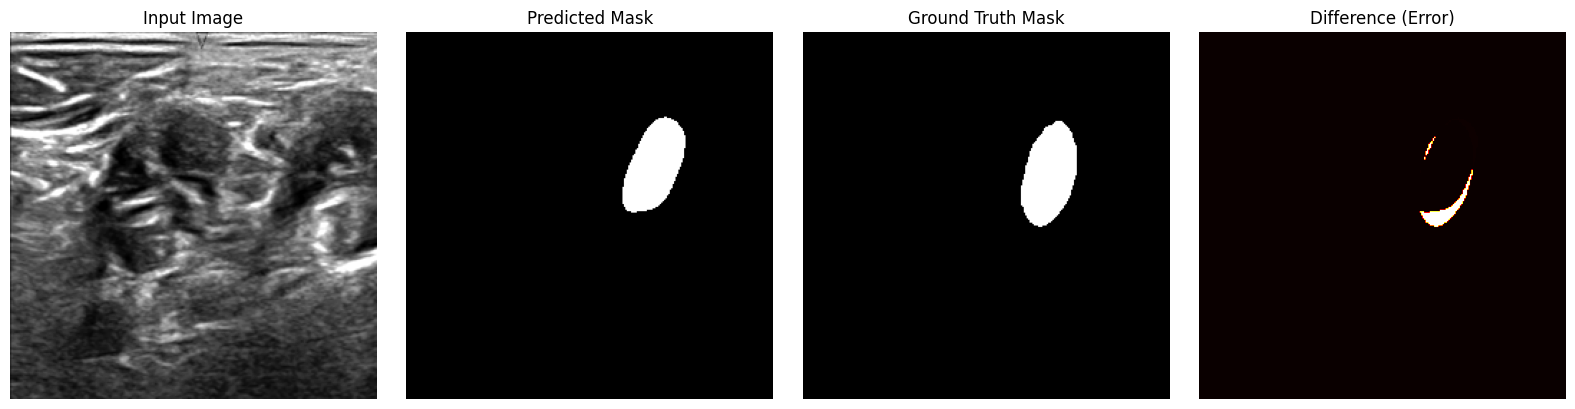

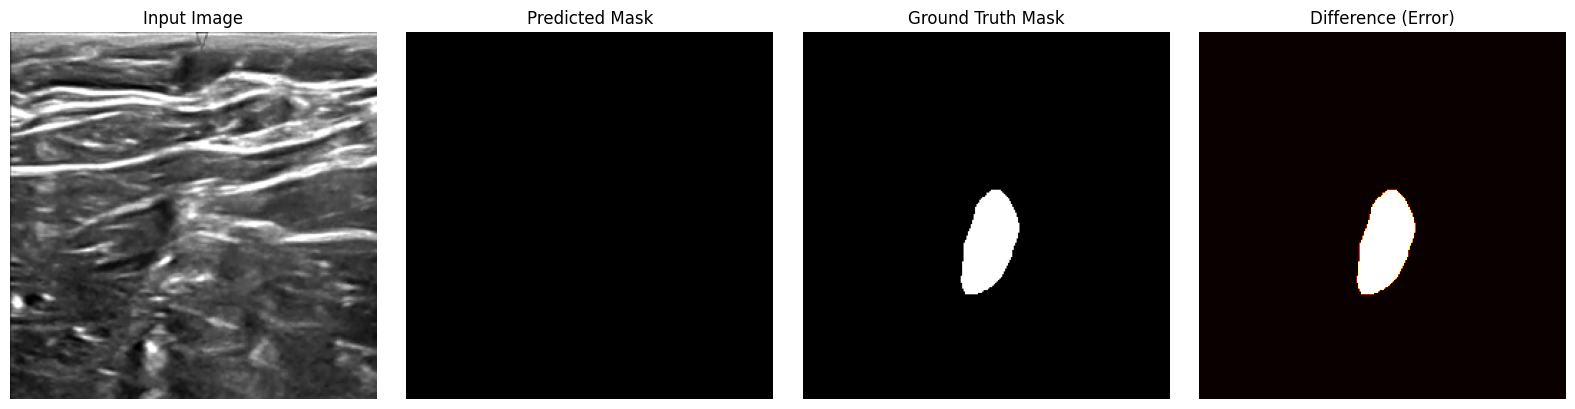

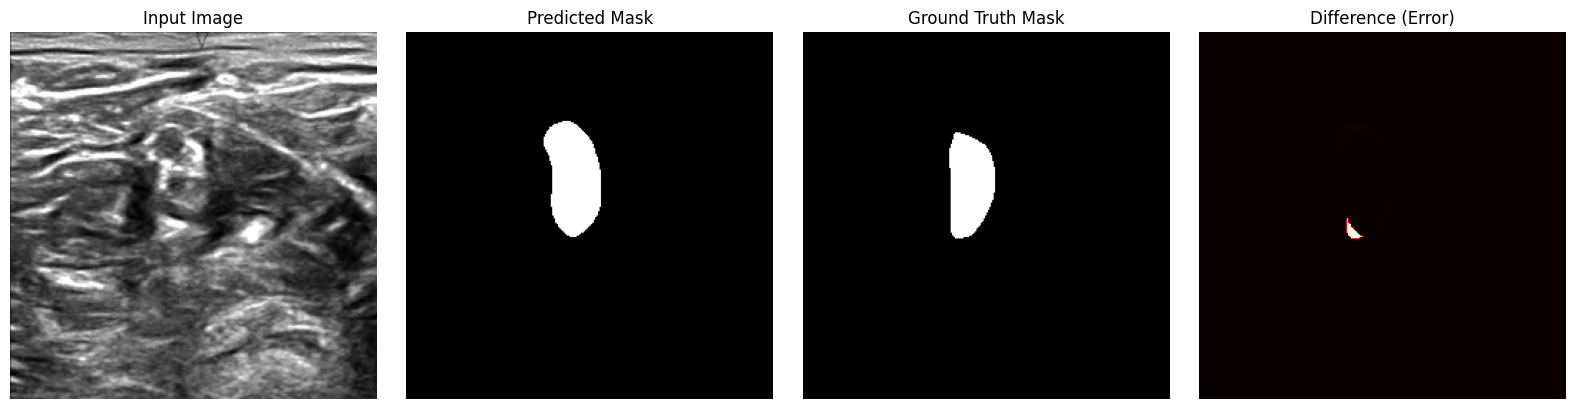

In [85]:
# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18(out_channels=1, pretrained=False).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def to_3channel(img_tensor):
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

# --- Get one batch from test_loader ---
images, masks = next(iter(test_loader))
images3 = to_3channel(images).to(device)
with torch.no_grad():
    outputs = model(images3)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).cpu().numpy().astype("uint8")

images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy().astype("uint8")

# Plotting
batch_size = images.shape[0]
for i in range(batch_size):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    # Input image
    axs[0].imshow(images_np[i, 0], cmap="gray")
    axs[0].set_title("Input Image")
    axs[0].axis("off")
    # Predicted mask
    axs[1].imshow(preds[i, 0], cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")
    # Ground Truth
    axs[2].imshow(masks_np[i, 0], cmap="gray")
    axs[2].set_title("Ground Truth Mask")
    axs[2].axis("off")
    # Difference (highlight error pixels)
    diff = np.abs(preds[i, 0] - masks_np[i, 0])
    axs[3].imshow(diff, cmap="hot")
    axs[3].set_title("Difference (Error)")
    axs[3].axis("off")
    plt.tight_layout()
    plt.show()